In [1]:
!pip install mlxtend --quiet

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [3]:
df = pd.read_csv('/content/orders_data_market_basket_analysis.csv')
print(df.shape)
df.head()

(9994, 9)


,Order ID,Order Date,Product ID,Category,Product Subcategory,Sales,Quantity,Discount,Profit
0,CA-2017-152156,11/8/2017,FUR-BO-10001798,Furniture,Bookcases,261.9600,2,0.00,41.9136
1,CA-2017-152156,11/8/2017,FUR-CH-10000454,Furniture,Chairs,731.9400,3,0.00,219.5820
2,CA-2017-138688,6/12/2017,OFF-LA-10000240,Office Supplies,Labels,14.6200,2,0.00,6.8714
3,US-2016-108966,10/11/2016,FUR-TA-10000577,Furniture,Tables,957.5775,5,0.45,-383.0310
4,US-2016-108966,10/11/2016,OFF-ST-10000760,Office Supplies,Storage,22.3680,2,0.20,2.5164


In [4]:
### Group by Order ID and agg Product Subcategory into lisst
basket = df.groupby(['Order ID'])['Product Subcategory'].apply(list)
basket

,Product Subcategory
Order ID,
CA-2015-100006,[Phones]
CA-2015-100090,"[Tables, Binders]"
CA-2015-100293,[Paper]
CA-2015-100328,[Binders]
CA-2015-100363,"[Fasteners, Paper]"
...,...
US-2018-168802,[Binders]
US-2018-169320,"[Art, Accessories]"
US-2018-169488,"[Paper, Paper]"


In [5]:
### Basket to binaryEnocder
te = TransactionEncoder()
te_ary = te.fit(basket).transform(basket)

# arr -> df
df = pd.DataFrame(te_ary, columns=te.columns_)
df

,Accessories,Appliances,Art,Binders,Bookcases,Chairs,Copiers,Envelopes,Fasteners,Furnishings,Labels,Machines,Paper,Phones,Storage,Supplies,Tables
0,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
3,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5004,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
5005,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5006,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
5007,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


In [6]:
# Apriori alogorithm to find freq itemmsets (min_sup = 1%)
freq_itemsets = apriori(df, min_support=1e-2, use_colnames=True)
freq_itemsets

,support,itemsets
0,0.143342,(Accessories)
1,0.090038,(Appliances)
2,0.145937,(Art)
3,0.262727,(Binders)
4,0.044720,(Bookcases)
...,...,...
63,0.023358,"(Phones, Storage)"
64,0.010381,"(Phones, Tables)"
65,0.010182,"(Binders, Furnishings, Paper)"
66,0.010781,"(Binders, Paper, Phones)"


In [7]:
freq_itemset_top10 = freq_itemsets.sort_values('support', ascending=False).head(10)
freq_itemset_top10 = freq_itemset_top10.reset_index(drop=True)
freq_itemset_top10

,support,itemsets
0,0.262727,(Binders)
1,0.237772,(Paper)
2,0.175085,(Furnishings)
3,0.162507,(Phones)
4,0.155121,(Storage)
5,0.145937,(Art)
6,0.143342,(Accessories)
7,0.114993,(Chairs)
8,0.090038,(Appliances)
9,0.069076,(Labels)


In [8]:
# 2-itemsets
two_pairs = freq_itemsets[freq_itemsets['itemsets'].apply(lambda x: len(x) == 2)]
two_pairs = two_pairs.sort_values('support', ascending=False)
print(f'two_pairs = {two_pairs.shape}')
two_pairs.head()

two_pairs = (48, 2)


,support,itemsets
43,0.054901,"(Binders, Paper)"
44,0.039728,"(Binders, Phones)"
45,0.039728,"(Binders, Storage)"
41,0.039529,"(Binders, Furnishings)"
61,0.035536,"(Paper, Storage)"


In [9]:
two_pairs['item_1'] = two_pairs['itemsets'].apply(lambda x: list(x)[0])
two_pairs['item_2'] = two_pairs['itemsets'].apply(lambda x: list(x)[1])
two_pairs.shape

(48, 4)

In [10]:
# create pivot table (2-pairs heatmap)
heatmap_two_pairs = pd.crosstab(two_pairs['item_1'], two_pairs['item_2'], values=two_pairs['support'], aggfunc='mean', dropna=True)
print(heatmap_two_pairs.shape)
heatmap_two_pairs

(10, 13)


item_2,Accessories,Appliances,Art,Bookcases,Chairs,Envelopes,Fasteners,Furnishings,Labels,Paper,Phones,Storage,Tables
item_1,,,,,,,,,,,,,
Accessories,NaN,0.011978,NaN,NaN,0.012777,NaN,NaN,NaN,NaN,0.030545,NaN,0.020563,NaN
Art,0.017768,0.011779,NaN,NaN,0.016371,NaN,NaN,0.019964,NaN,0.029946,NaN,0.019964,NaN
Binders,0.032142,0.025953,0.029946,0.01118,0.023757,0.010781,0.012378,0.039529,0.016371,0.054901,0.039728,0.039728,0.014174
Chairs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016570,NaN
Furnishings,0.022959,0.015971,NaN,NaN,0.019764,NaN,NaN,NaN,0.011380,0.035336,NaN,0.027550,NaN
Labels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.012178,NaN
Paper,NaN,0.021761,NaN,NaN,0.026552,0.011380,0.011779,NaN,0.015971,NaN,NaN,0.035536,NaN
Phones,0.023158,0.015173,0.024755,NaN,0.017768,NaN,NaN,0.029547,0.011579,0.034937,NaN,0.023358,0.010381
Storage,NaN,0.011180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


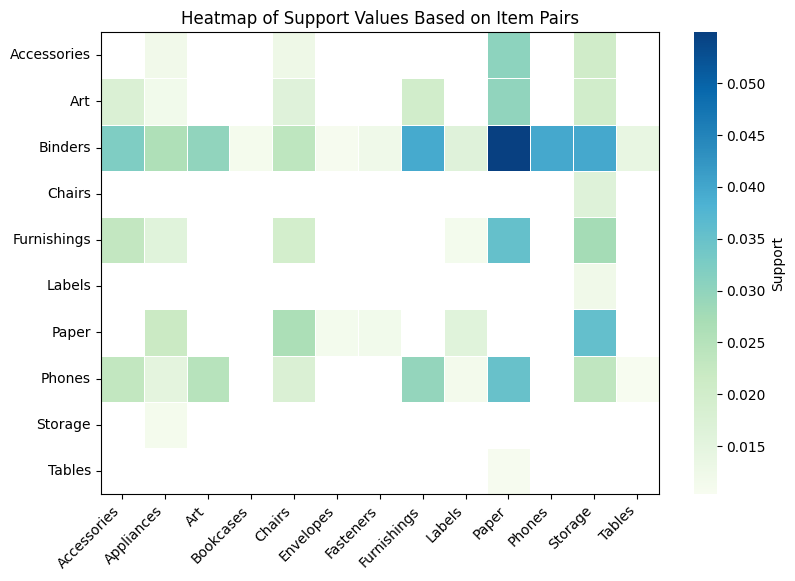

In [11]:
plt.figure(figsize=(9, 6))
sns.heatmap(heatmap_two_pairs, cmap='GnBu', annot=False, fmt='.1f', cbar_kws={'label': 'Support'}, linewidths=0.5)
plt.title("Heatmap of Support Values Based on Item Pairs")
plt.xticks(rotation=45, ha='right')

plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.xlabel('')
plt.ylabel('')

plt.show()

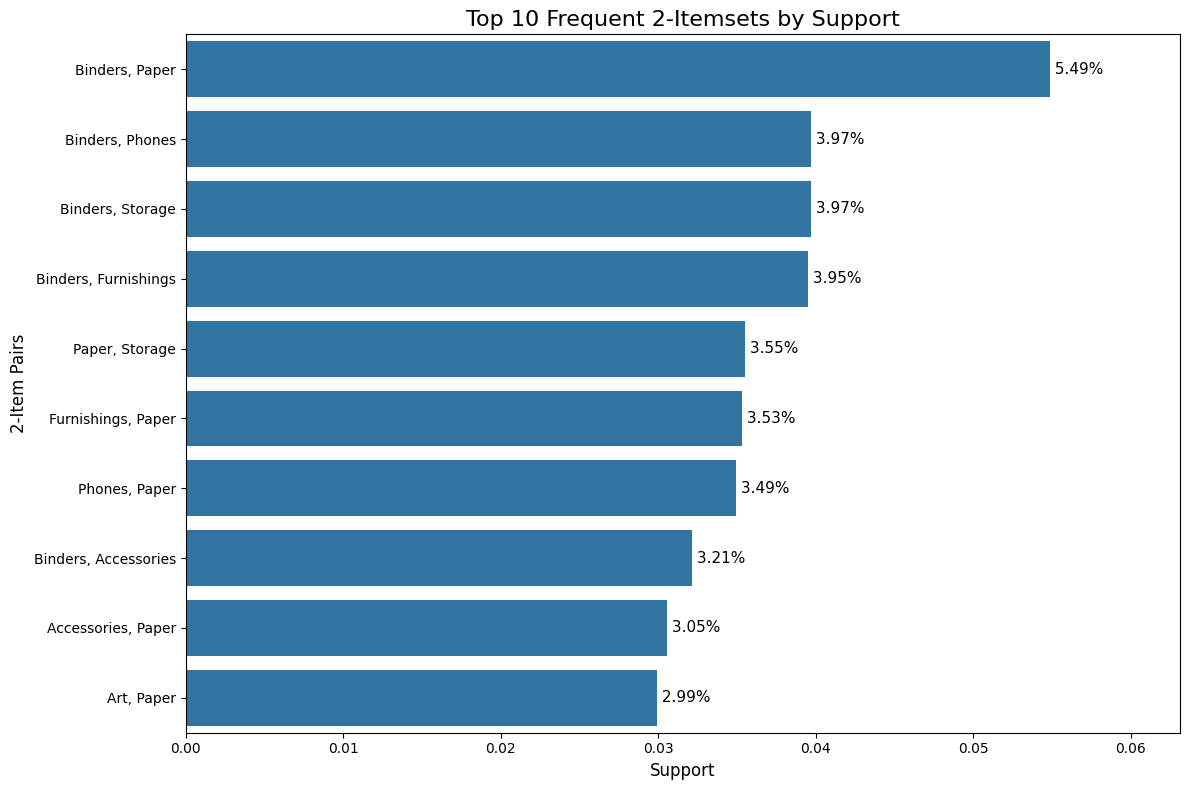

In [12]:

def top_freq_itemsets(freq_itemsets, n, top):

    top_freq = freq_itemsets[freq_itemsets['itemsets'].apply(lambda x: len(x) == n)].sort_values('support', ascending=False).head(top)
    top_freq['item_labels'] = top_freq['itemsets'].apply(lambda x: ', '.join(x))

    plt.figure(figsize=(12, 8))
    barplot = sns.barplot(x='support', y='item_labels', data=top_freq, orient='h')
    for index, value in enumerate(top_freq['support']):
        label = f'{value:.2%}'
        plt.text(value, index, ' ' + label, va='center', ha='left', fontsize=11)

    plt.title(f'Top {top} Frequent {n}-Itemsets by Support', fontsize=16)
    plt.xlabel('Support', fontsize=12)
    plt.ylabel(f'{n}-Item Pairs', fontsize=12)
    plt.xlim(0, top_freq['support'].max() * 1.15)
    plt.tight_layout()
    plt.show()

top_freq_itemsets(freq_itemsets, n=2, top=10)


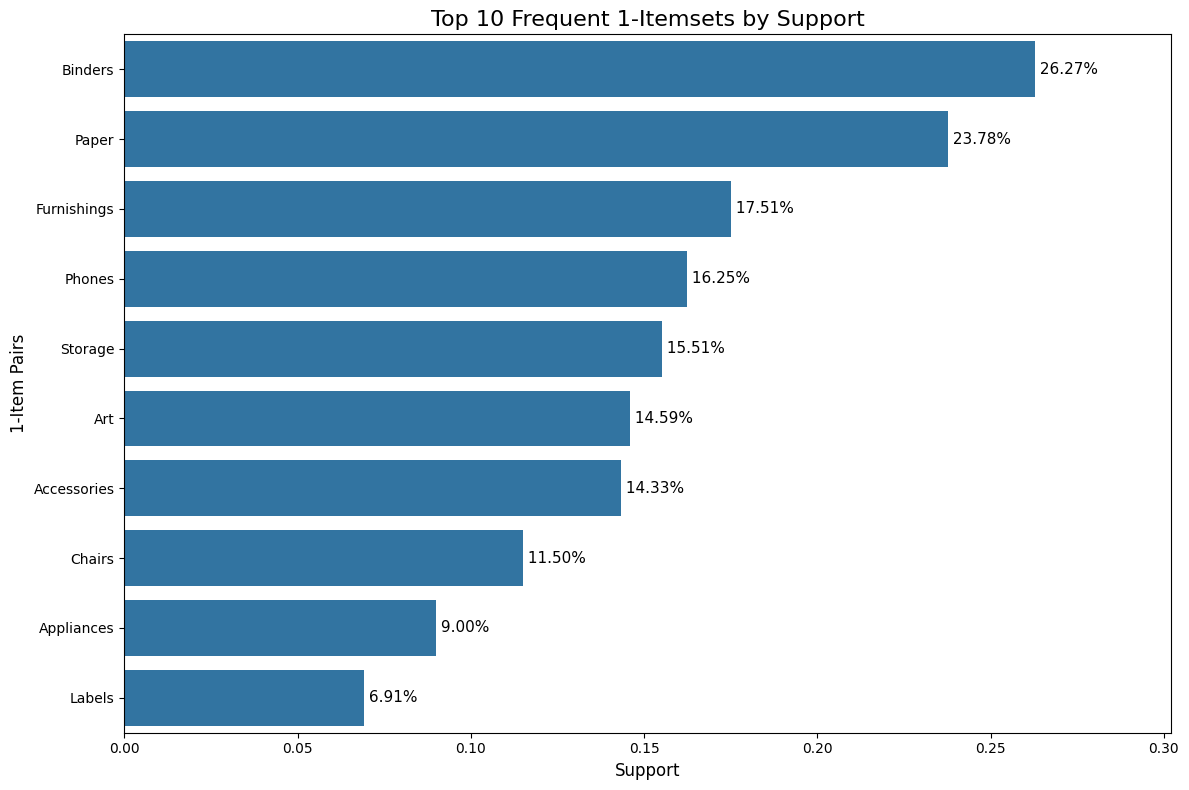

In [13]:
top_freq_itemsets(freq_itemsets, n=1, top=10)

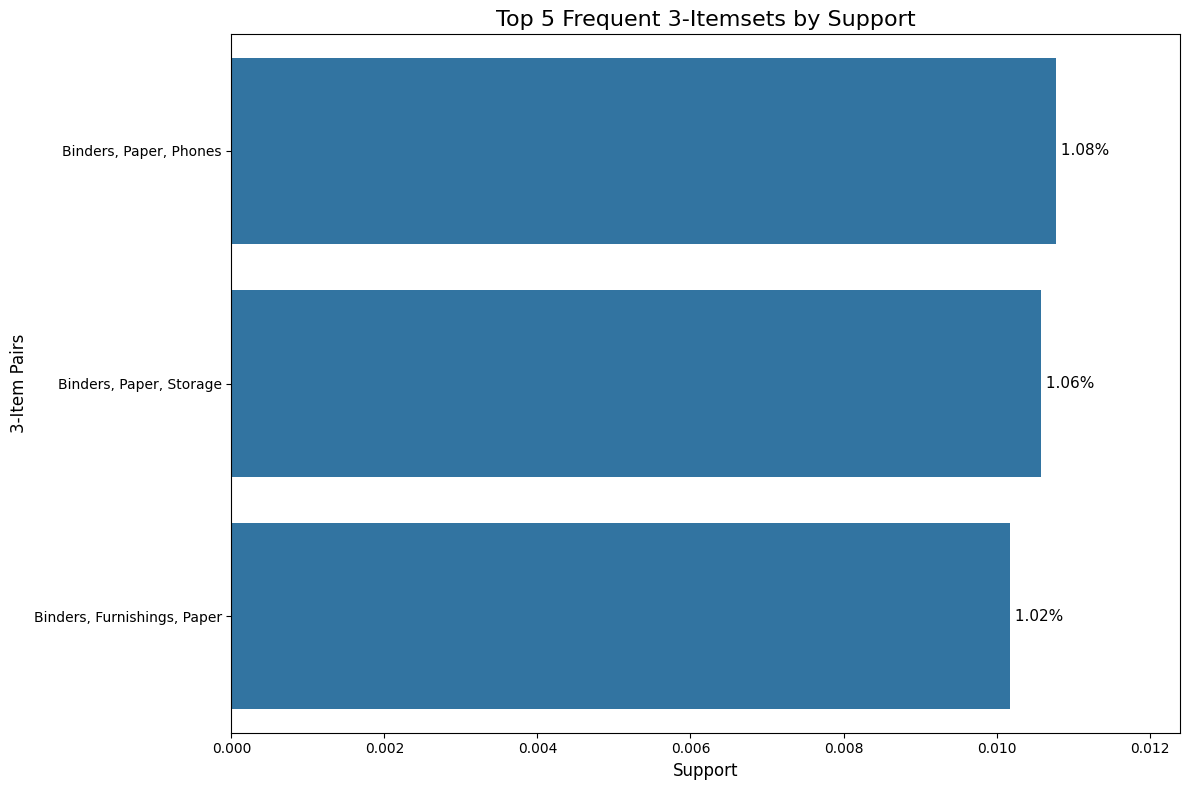

In [14]:
top_freq_itemsets(freq_itemsets, n=3, top=5)

In [15]:
raw_rules = association_rules(freq_itemsets, metric="lift", min_threshold=1)
rules = raw_rules[['antecedents', 'consequents', 'antecedent support', 'consequent support', 'support', 'confidence', 'lift']].sort_values(by="lift", ascending=False)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
41,(Storage),"(Binders, Paper)",0.155121,0.054901,0.010581,0.068211,1.242434
36,"(Binders, Paper)",(Storage),0.054901,0.155121,0.010581,0.192727,1.242434
30,"(Binders, Paper)",(Phones),0.054901,0.162507,0.010781,0.196364,1.208336
35,(Phones),"(Binders, Paper)",0.162507,0.054901,0.010781,0.066339,1.208336
33,(Binders),"(Phones, Paper)",0.262727,0.034937,0.010781,0.041033,1.174494
32,"(Phones, Paper)",(Binders),0.034937,0.262727,0.010781,0.308571,1.174494
13,(Fasteners),(Paper),0.042923,0.237772,0.011779,0.274419,1.154125
12,(Paper),(Fasteners),0.237772,0.042923,0.011779,0.049538,1.154125
34,(Paper),"(Binders, Phones)",0.237772,0.039728,0.010781,0.045340,1.141248
31,"(Binders, Phones)",(Paper),0.039728,0.237772,0.010781,0.271357,1.141248


In [16]:
rules['rule'] = rules['antecedents'].apply(lambda x: ','.join(sorted(x))) + " --> " + rules['consequents'].apply(lambda x: ','.join(sorted(x)))
rules = rules[['rule'] + [col for col in rules.columns if col != 'rule']]
rules = rules.reset_index(drop=True)
rules

,rule,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
0,"Storage --> Binders,Paper",(Storage),"(Binders, Paper)",0.155121,0.054901,0.010581,0.068211,1.242434
1,"Binders,Paper --> Storage","(Binders, Paper)",(Storage),0.054901,0.155121,0.010581,0.192727,1.242434
2,"Binders,Paper --> Phones","(Binders, Paper)",(Phones),0.054901,0.162507,0.010781,0.196364,1.208336
3,"Phones --> Binders,Paper",(Phones),"(Binders, Paper)",0.162507,0.054901,0.010781,0.066339,1.208336
4,"Binders --> Paper,Phones",(Binders),"(Phones, Paper)",0.262727,0.034937,0.010781,0.041033,1.174494
5,"Paper,Phones --> Binders","(Phones, Paper)",(Binders),0.034937,0.262727,0.010781,0.308571,1.174494
6,Fasteners --> Paper,(Fasteners),(Paper),0.042923,0.237772,0.011779,0.274419,1.154125
7,Paper --> Fasteners,(Paper),(Fasteners),0.237772,0.042923,0.011779,0.049538,1.154125
8,"Paper --> Binders,Phones",(Paper),"(Binders, Phones)",0.237772,0.039728,0.010781,0.045340,1.141248
9,"Binders,Phones --> Paper","(Binders, Phones)",(Paper),0.039728,0.237772,0.010781,0.271357,1.141248


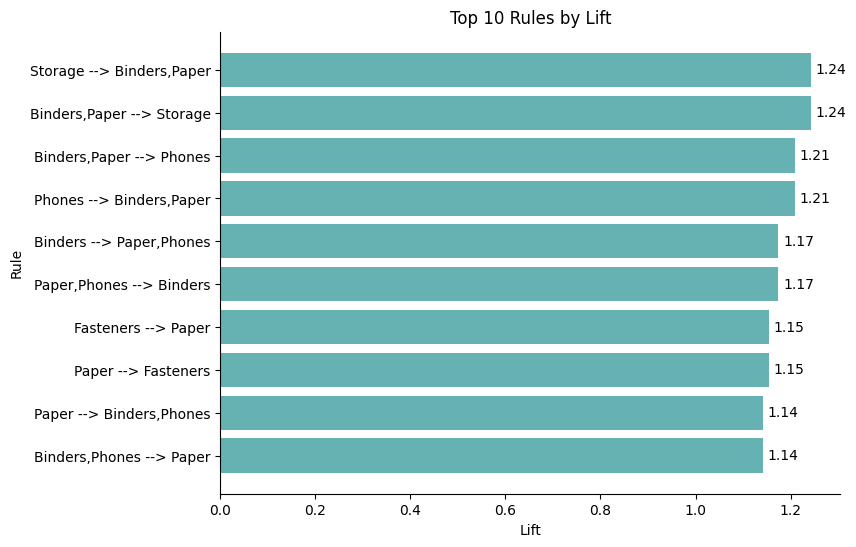

In [17]:
rule = rules['rule'].head(10)
lift_values = rules['lift'].head(10)

plt.figure(figsize=(8, 6))

bars = plt.barh(rule, lift_values, color='#66b2b2')

for bar in bars:
    plt.text(
        bar.get_width() + 0.01,
        bar.get_y() + bar.get_height() / 2,
        f'{bar.get_width():.2f}',
        va='center',
        ha='left',
        color='black',
        fontsize=10
    )

plt.xlabel('Lift')
plt.ylabel('Rule')
plt.title('Top 10 Rules by Lift')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.gca().invert_yaxis()

plt.show()